### Reproducing the results of the paper

In [5]:
%pip install -r requirements.txt

# Imports
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import LogNorm
from scipy.special import digamma, gammaln, logsumexp
from scipy.stats import multivariate_normal


def fit_predict(X,nb_components=10,max_iter=10,seed=0):
    
    # Sizes
    n, d = X.shape
        
    # Initialization
    rd = np.random.RandomState(seed)
    resp = rd.rand(n, nb_components)/resp.sum(axis=1)[:, np.newaxis]
    nu0,invW0,beta0 = d,np.atleast_2d(np.cov(X.T)),1.
    weights = np.ones(nb_components) / nb_components
    expectation = [np.zeros((nb_components, d)),np.array([nu0 * np.linalg.inv(invW0) for _ in range(nb_components)]),np.zeros(nb_components),np.zeros((nb_components, d, d))]

    # First parameter update
    eta = resp.sum(axis=0) + 10*np.finfo(resp.dtype).eps  
    nu = nu0 + eta  
    S = beta0 * np.eye(d) + expectation[1] * eta[:,np.newaxis,np.newaxis]  
    inverse_S = np.linalg.inv(S)
    inverse_W = np.zeros((nb_components, d, d))  
    m = np.zeros((nb_components, d))  
    for k in range(nb_components):
        m[k] = inverse_S[k]@expectation[1][k]@(resp[:, k]@X)  
        s = np.zeros((d, d))
        for i in range(n):
            s += resp[i, k] * (np.outer(X[i], X[i]) - np.outer(X[i], expectation[0][k]) - np.outer(expectation[0][k], X[i]) +  expectation[3][k])  
            inverse_W[k] = invW0 + s 
        
    # Initializing the lower bound
    lower_bound = np.zeros(max_iter)

    # EM procedure
    for p in range(max_iter):
            
        # Computing expectation values
        expectation=[]
        expectation.append(m.copy())
        expectation.append(nu[:, np.newaxis, np.newaxis] * np.linalg.inv(inverse_W))
        expectation.append(d*np.log(2) - np.log(np.linalg.det(inverse_W)) +  np.sum(digamma(0.5*(nu - np.arange(d)[:,np.newaxis]))))
        inverse_S = np.linalg.inv(S)
        expectation.append([inverse_S[i] + np.outer(m[i],m[i]) for i in range(nb_components)])                                                                                                   
        expectation.append([np.trace(inverse_S[i]) + m[i]@m[i] for i in range(nb_components)])
            
        # Computing probabilities                                                                                         
        log_rho_tilde = np.zeros((n, nb_components))
        for i in range(n):
            for j in range(nb_components):
                log_rho_tilde[i, j] = 0.5*expectation[2][j]-0.5*np.trace(expectation[1][j]@(np.outer(X[i],X[i])-np.outer(X[i], expectation[0][j])-np.outer(expectation[0][j], X[i])+expectation[3][j]))
        log_rho = log_rho_tilde + np.log(weights + 10 * np.finfo(weights.dtype).eps)
        log_resp = log_rho - logsumexp(log_rho, axis=1)[:, np.newaxis]
            
        # Computing resp
        resp = np.exp(log_resp)
            
        # Updating parameters
        eta = resp.sum(axis=0) + 10*np.finfo(resp.dtype).eps 
        nu = nu0 + eta
        S = beta0 * np.eye(d) + expectation[1] * eta[:,np.newaxis,np.newaxis]
        inverse_S = np.linalg.inv(S)
        inverse_W = np.zeros((nb_components, d, d))
        m = np.zeros((nb_components, d))
        for k in range(nb_components):
            m[k] = inverse_S[k]@expectation[1][k]@(resp[:, k]@X)
            s = np.zeros((d, d))
            for i in range(n):
                s += resp[i, k] * (np.outer(X[i], X[i]) - np.outer(X[i], expectation[0][k])- np.outer(expectation[0][k], X[i]) +  expectation[3][k])
            inverse_W[k] = invW0 + s
            
        # M-step
        weights = resp.sum(axis=0) / resp.sum()
            
        # Computing the lower bound
        ln_p_x = np.sum(resp * (log_rho_tilde))
        ln_p_z = np.sum(resp * np.log(weights))
        ln_p_mu = nb_components * d * np.log(0.5 * beta0 / np.pi) - 0.5 * beta0 * np.sum(expectation[4]) 
        ln_p_T = nb_components * log_wishart_B(invW0, nu0)+ 0.5 * (nu0 - d - 1) * expectation[2].sum()- 0.5 * np.trace(invW0 * expectation[1].sum())
        ln_q_z = np.sum(resp * np.log(resp))  
        ln_q_mu = - 0.5 * nb_components * d * (1 + np.log(2 * np.pi)) + 0.5 * np.sum(np.log(np.linalg.det(S))) 
        ln_q_T  = np.sum([log_wishart_B(inverse_W[k], nu[k]) for k in range(nb_components)]) + np.sum(0.5 * (nu - d - 1) * expectation[2]) - np.sum(0.5 * np.trace(inverse_W @ expectation[1], axis1=1, axis2=2))
        lower_bound[p] = ln_p_x + ln_p_z + ln_p_mu + ln_p_T + ln_q_z + ln_q_mu + ln_q_T
        
        # Displaying every ten iterations the result
        if p % 10 == 0:
            covs = inverse_W / nu[:, np.newaxis, np.newaxis]
            display_2D(m,covs,nb_components,weights,X)
            plt.title('iteration '+ str(p))
            plt.show()

    # Final parameter update
    covs = inverse_W / nu[:, np.newaxis, np.newaxis]
    display_2D(m,covs,nb_components,weights,X)
    plt.title('iteration '+ str(p))
    plt.show()
    
            
def log_wishart_B(inverse_W, nu):
    d = len(inverse_W)
    return + 0.5 * nu * np.log(np.linalg.det(inverse_W)) - 0.5 * nu * d * np.log(2) - 0.25 * d * (d-1) * np.log(np.pi) - gammaln(0.5 * (nu - np.arange(d))).sum()

        
def display_2D(m,covs,nb_components,weights, X):
    
    # Grid
    xmin, xmax, ymin, ymax = X[:,0].min(), X[:,0].max(), X[:,1].min(), X[:,1].max()
    mx, my =.1 * (xmax - xmin), .1 * (ymax - ymin)  # margins
    xmin, xmax, ymin, ymax = xmin - mx, xmax + mx, ymin - my, ymax + my
    x = np.linspace(xmin, xmax, 200)
    y = np.linspace(ymin, ymax, 200)
    x, y = np.meshgrid(x, y)
    pos = np.empty(x.shape + (2,))
    pos[:,:,0] = x; pos[:,:,1] = y
    
    # Distributions
    rvs = [multivariate_normal(m[k], covs[k]) for k in range(nb_components)]   
    Z = sum([weights[k] * rvs[k].pdf(pos) for k in range(nb_components)])

    # Figure
    plt.figure(figsize=(6,6))
        
    # Dataset plot
    plt.plot(*X.T, '.', c='k')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    # Component distributions
    ax = plt.gca()
    for k in range(nb_components):
        if weights[k] >= 1e-5:
            plot_confidence_ellipse(m[k], covs[k], 0.9, ax=ax,ec='black',alpha=max(0.3, weights[k] / max(weights)))
                   
                    
def plot_confidence_ellipse(mu, cov, alph, ax, clabel=None, label_bg='white', **kwargs):
    c = -2 * np.log(1 - alph)  # quantile at alpha of the chi_squarred distr. with df = 2
    Lambda, Q = la.eig(cov)  # eigenvalues and eigenvectors (col. by col.)
    
    # Compute the attributes of the ellipse
    width, heigth = 2 * np.sqrt(c * Lambda)
    
    # compute the value of the angle theta (in degree)
    theta = 180 * np.arctan(Q[1,0] / Q[0,0]) / np.pi if cov[1,0] else 0
        
    # Create the ellipse
    if 'fc' not in kwargs.keys():
        kwargs['fc'] = 'None'
    level_line = Ellipse(mu, width, heigth, angle=theta, **kwargs)
        
    return ax.add_patch(level_line)

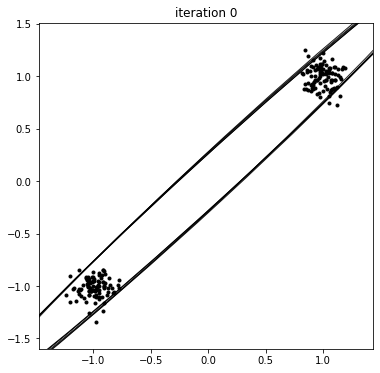

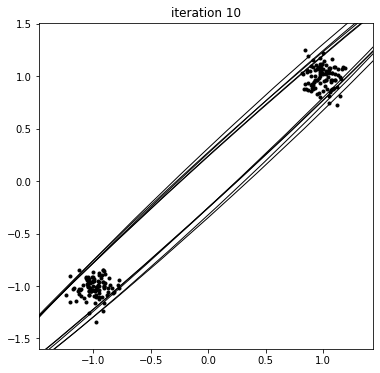

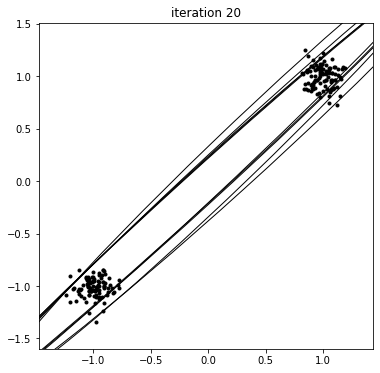

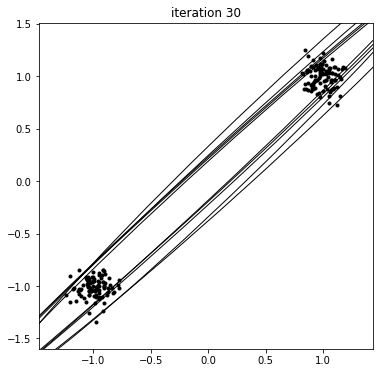

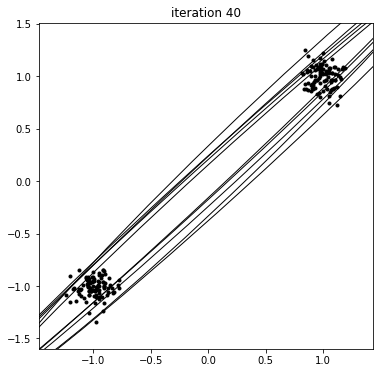

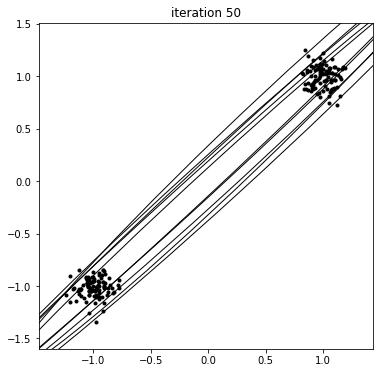

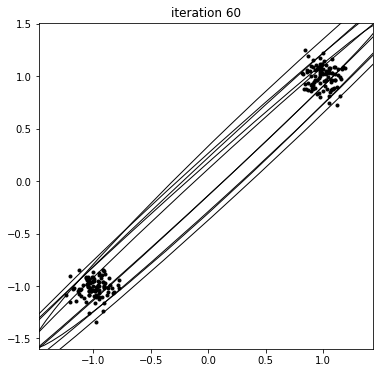

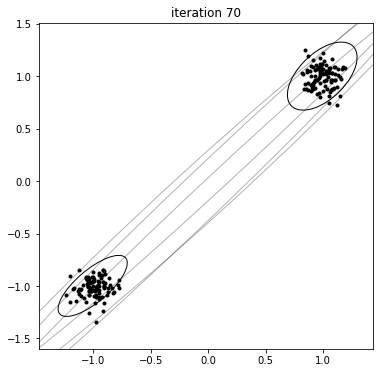

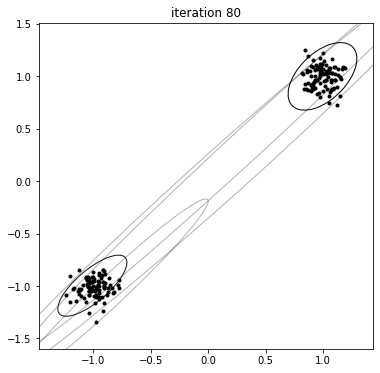

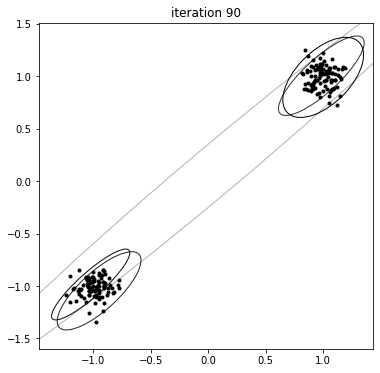

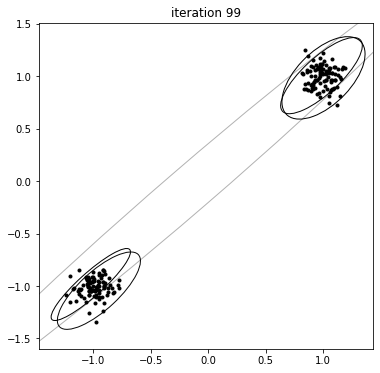

In [6]:
# Dataset creation
dataset_1 = np.random.multivariate_normal(mean=[1,1],cov=[[0.01,0],[0,0.01]],size=(100))
dataset_2 = np.random.multivariate_normal(mean=[-1,-1],cov=[[0.01,0],[0,0.01]],size=(100))
dataset = np.vstack((dataset_1,dataset_2))

# Training and visualization of the iterations
fit_predict(dataset,nb_components=5,max_iter=100)